In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = "/content/drive/My Drive/Colab Notebooks/NN_project"
models_path = path+"/"+'models/'

isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)
  print("NN_project directory is created!")

isExist = os.path.exists(models_path)
if not isExist:
  os.makedirs(models_path)
  print("Models directory is created!")

os.chdir(path)
!ls

Mounted at /content/drive
kaggle.json  models


# Import Libraries

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
#import cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
#from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Dense, Lambda, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import files

uploaded = files.upload()


In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
#copy kaggle.json file 
!cp kaggle.json ~/.kaggle/
!ls

mkdir: cannot create directory ‘/root/.kaggle’: File exists
kaggle.json  models


In [ ]:
from os.path import exists
# dataset = "flowers-recognition.zip"
dataset = "fruits.zip"

def downloadDataset():
  # !kaggle datasets download -d alxmamaev/flowers-recognition
  # !unzip flowers-recognition.zip
  
  !kaggle datasets download -d moltean/fruits
  !unzip fruits.zip

is_exists = exists(dataset)#'fruits.zip'
if not is_exists:
  downloadDataset()

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini

### Variables

In [ ]:
batch_size = 512
classes=131
img_size=32
total_images=4317
epochs = 100

# Data Preparation

In [ ]:
# create a data generator
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2) #

dataset_path = 'fruits-360_dataset/fruits-360/Training/'
# dataset_path = 'flowers/'


# load and iterate training dataset
train_dataset = datagen.flow_from_directory(directory=dataset_path, 
                                       class_mode='categorical', 
                                       target_size=(img_size, img_size),
                                       color_mode="rgb",
                                       batch_size=batch_size,
                                       subset="training",
                                       shuffle=True,
                                       seed=123)


validation_dataset = datagen.flow_from_directory(directory=dataset_path, 
                                       class_mode='categorical', 
                                       target_size=(img_size, img_size),
                                       color_mode="rgb",
                                       batch_size=batch_size,
                                       subset="validation",
                                       shuffle=True,
                                       seed=123)


Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


In [ ]:
# Previous
'''@tf.function
def lRelu(X, alpha=0.0, beta=1.0):
  return K.switch(X<0,X,X)
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'lrelu': Activation(lRelu)})'''

"@tf.function\ndef lRelu(X, alpha=0.0, beta=1.0):\n  return K.switch(X<0,X,X)\nfrom keras.utils.generic_utils import get_custom_objects\n\nget_custom_objects().update({'lrelu': Activation(lRelu)})"

In [ ]:

def lRelu(X, alpha=0.001, beta=0.95,dtype=tf.float32):
  zero = tf.constant(0.)
  one = tf.constant(1.0)
  alpha = tf.convert_to_tensor(alpha)
  beta = tf.convert_to_tensor(beta)
  def negative(X):
    #print('Negative is getting calll......')
    return X*alpha
  def positive(X):
    #print('Positive is getting calll.....')
    return X*beta
  return K.switch(tf.less(X,zero), lambda:negative(X), lambda:positive(X))
  #return K.switch(, tf.math.multiply(X,beta), tf.math.multiply(X,alpha))
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'lrelu': Activation(lRelu)})

In [ ]:
 # RESNET50 WITH SKIP CONNECTION 2: Implemented by Lokesh
def createStageOne(x, filters,kernels, strides,paddings,counter):
  '''
  Argument
  x - input
  f - filter_size
  k - kernel size
  s - stride
  p - padding
  '''
  f1, f2 = filters
  k1, k2 = kernels
  s1, s2 = strides
  p1, p2 = paddings
  block_name = 'stage_1'+counter
  x_skip = x
  x = Conv2D(f1, kernel_size=(k1,k1),strides=(s1,s1),padding=p1, name=block_name+'a')(x)
  x = BatchNormalization()(x)
  x = Activation('lrelu')(x)
  #x = Lambda(lRelu)(x)
  x = Conv2D(f2,kernel_size=(k2,k2),strides=(s2,s2),padding=p2,name=block_name+'b')(x)
  x = BatchNormalization()(x)

  x_skip = Conv2D(f2,kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('lrelu')(x)
  #x = Lambda(lRelu)(x)
  #print("After Activation at state 1:",(x.shape,x.dtype))
  #print("Stage 1:", x.shape)

  return x


In [ ]:
def createStageTwo(x,filters,kernels,strides,paddings,counter):
  '''
  Arguments
  x - input
  filters - filter size
  kernels - kernel size
  strides - stride size
  paddings - padding size
  '''
  #print("stage 2", x.shape)
  f1, f2 = filters
  k1, k2 = kernels
  s1, s2 = strides
  p1, p2 = paddings
  block_name = 'stage_2'+counter
  x_skip = x
  x = Conv2D(f1,kernel_size=(k1,k1),strides=(s1,s1),padding=p1,name=block_name+'a')(x)
  x = BatchNormalization()(x)
  x = Activation('lrelu')(x)
  #x = Lambda(lRelu)(x)
  #print("After Activation at state 2:",(x.shape,x.dtype))
  x = Conv2D(f2,kernel_size=(k2,k2),strides=(s2,s2),padding=p2,name=block_name+'b')(x)
  x = BatchNormalization()(x)
  if x.shape[1] != x_skip.shape[1]:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(2,2),padding='valid')(x_skip)
  else:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('lrelu')(x)
  #x = Lambda(lRelu)(x)
  #print("After Activation at state 2:",(x.shape,x.dtype))
  #print('Stage 2:',x.shape)
  return x

In [ ]:
def createStageThree(x,filters,kernels,strides,paddings,counter):
  '''
  Arguments
  x - input
  filters - filter size
  kernels - kernel size
  strides - stride size
  paddings - padding size
  '''
  f1, f2 = filters
  k1, k2 = kernels
  s1, s2 = strides
  p1, p2 = paddings
  block_name = 'stage_3'+counter
  x_skip = x
  x = Conv2D(f1,kernel_size=(k1,k1),strides=(s1,s1),padding=p1,name=block_name+'a')(x)
  x = BatchNormalization()(x)
  x = Activation('lrelu')(x)
  #x = Lambda(lRelu)(x)
  #print("After FirstLambda at state 3:",(x.shape,x.dtype))
  x = Conv2D(f2,kernel_size=(k2,k2),strides=(s2,s2),padding=p2,name=block_name+'b')(x)
  x = BatchNormalization()(x)
  if x.shape[1] != x_skip.shape[1]:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(2,2),padding='valid')(x_skip)
  else:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('lrelu')(x)
  #x = Lambda(lRelu)(x)
  #print("After Activation at state 3:",(x.shape,x.dtype))
  #print('Stage 3:',x.shape)
  return x

In [ ]:
from keras.layers import LeakyReLU
def createStageFour(x,filters,kernels,strides,paddings,counter):
  '''
  Arguments
  x - input
  filters - filter size
  kernels - kernel size
  strides - stride size
  paddings - padding size
  '''
  #print("stage 4", x.shape)
  f1, f2 = filters
  k1, k2 = kernels
  s1, s2 = strides
  p1, p2 = paddings
  block_name = 'stage_4'+counter
  x_skip = x
  x = Conv2D(f1,kernel_size=(k1,k1),strides=(s1,s1),padding=p1,name=block_name+'a')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #x = Lambda(lRelu)(x)
  x = Conv2D(f2,kernel_size=(k2,k2),strides=(s2,s2),padding=p2,name=block_name+'b')(x)
  x = BatchNormalization()(x)
  if x.shape[1] != x_skip.shape[1]:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(2,2),padding='valid')(x_skip)
  else:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  #print("stage 4: Skip", x_skip.shape)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('relu')(x)
  #x = Lambda(lRelu)(x)
  return x

In [ ]:
def resnet50():
  inputs = Input(shape = (32,32,3), name = "image_input")
  x = ZeroPadding2D((3,3))(inputs)
  # Initial Convolutional block
  
  x = Conv2D(64, kernel_size=(7,7), strides = (2,2))(x)
  x = BatchNormalization()(x)
  x = Activation('lrelu')(x)
  #x = Lambda(lRelu)(x)
  #print("before Max pooling: ", x.shape)
  x = MaxPooling2D((3,3),strides=(2,2))(x)
  x = createStageOne(x,[64,64],[1,3],[1,1],['valid','same'],'1')
  x = createStageOne(x,[256,64],[1,1],[1,1],['valid','valid'],'2')
  x = createStageOne(x,[64,256],[3,1],[1,1],['same','valid'],'3')
  x = createStageOne(x,[64,64],[1,3],[1,1],['valid','same'],'4')
  x = createStageTwo(x,[256,128],[1,1],[1,2],['valid','valid'],'5')
  x = createStageTwo(x,[128,512],[3,1],[1,1],['same','valid'],'6')
  x = createStageTwo(x,[128,128],[1,3],[1,1],['valid','same'],'7')
  x = createStageTwo(x,[512,128],[1,1],[1,1],['valid','valid'],'8')
  x = createStageTwo(x,[128,512],[3,1],[1,1],['same','valid'],'9')
  x = createStageTwo(x,[128,128],[1,3],[1,1],['valid','same'],'10')
  x = createStageThree(x,[512,256],[1,1],[1,2],['valid','valid'],'11')
  x = createStageThree(x,[256,1024],[3,1],[1,1],['same','valid'],'12')
  x = createStageThree(x,[256,256],[1,3],[1,1],['valid','same'],'13')
  x = createStageThree(x,[1024,256],[1,1],[1,1],['valid','valid'],'14')
  x = createStageThree(x,[256,1024],[3,1],[1,1],['same','valid'],'15')
  x = createStageThree(x,[256,256],[1,3],[1,1],['valid','same'],'16')
  x = createStageThree(x,[1024,256],[1,1],[1,1],['valid','valid'],'17')
  x = createStageThree(x,[256,1024],[3,1],[1,1],['same','valid'],'18')
  x = createStageThree(x,[256,256],[1,3],[1,1],['valid','same'],'19')
  x = createStageFour(x,[1024,512],[1,1],[1,2],['valid','valid'],'20')
  x = createStageFour(x,[512,2048],[3,1],[1,1],['same','valid'],'21')
  x = createStageFour(x,[512,512],[1,3],[1,1],['valid','same'],'22')
  x = createStageFour(x,[2048,512],[1,1],[1,1],['valid','valid'],'23')
  x = createStageFour(x,[512,2048],[3,1],[1,1],['same','valid'],'24')
  x = AveragePooling2D((2,2),name='avg_pool',padding='same')(x)
  x = Flatten()(x)
  #print(x.shape)
  x = Dense(classes,activation='softmax')(x)
  model = Model(inputs=inputs,outputs=x, name='LResNet50')
  #print(x.shape)
  return model


# Model compiling and training

In [ ]:
model = resnet50()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "LResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['image_input[0][0]']            
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                               

In [ ]:

history = model.fit_generator(generator=train_dataset, steps_per_epoch=len(train_dataset), epochs=epochs, validation_data=validation_dataset, validation_steps=len(validation_dataset), verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
106/106 [==============================] - 95s 737ms/step - loss: 2.3594 - accuracy: 0.4069 - val_loss: 7.8124 - val_accuracy: 0.0109
Epoch 2/100
106/106 [==============================] - 75s 711ms/step - loss: 0.3541 - accuracy: 0.8918 - val_loss: 13.2238 - val_accuracy: 0.0071
Epoch 3/100
106/106 [==============================] - 75s 704ms/step - loss: 0.1413 - accuracy: 0.9553 - val_loss: 14.5815 - val_accuracy: 0.0117
Epoch 4/100
106/106 [==============================] - 74s 700ms/step - loss: 0.0851 - accuracy: 0.9743 - val_loss: 9.3073 - val_accuracy: 0.1341
Epoch 5/100
106/106 [==============================] - 74s 702ms/step - loss: 0.0691 - accuracy: 0.9796 - val_loss: 2.3396 - val_accuracy: 0.5951
Epoch 6/100
106/106 [==============================] - 75s 707ms/step - loss: 0.0690 - accuracy: 0.9792 - val_loss: 1.7637 - val_accuracy: 0.7691
Epoch 7/100
106/106 [==============================] - 76s 713ms/step - loss: 0.0579 - accuracy: 0.9831 - val_loss: 1.5913

### Save Model

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/NN_project/models/ResNet_Custom_modelv2.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


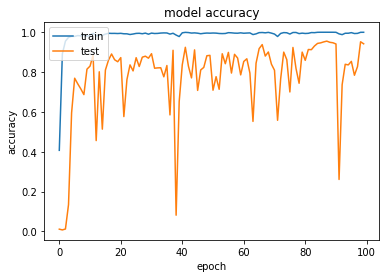

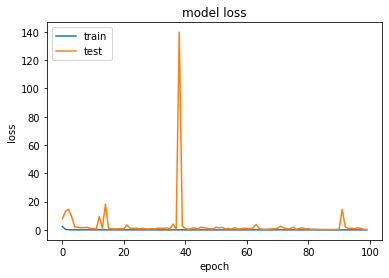

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Evaluation and Prediction

In [ ]:
dataset_path_test = 'fruits-360_dataset/fruits-360/Test/'

test_dataset = datagen.flow_from_directory(directory=dataset_path_test, 
                                       class_mode='categorical', 
                                       target_size=(img_size, img_size),
                                       color_mode="rgb",
                                       batch_size=batch_size,
                                       shuffle=True,
                                       seed=123)

Found 22688 images belonging to 131 classes.


In [ ]:
print('\nTraining accuracy: ', round(history.history['accuracy'][epochs-1]*100,2),'%')
print('Validation accuracy: ', round(history.history['val_accuracy'][epochs-1]*100, 2),'%')


Training accuracy:  99.98 %
Validation accuracy:  94.19 %


In [ ]:
loss, acc = model.evaluate(test_dataset, batch_size=batch_size)
print('\nTest accuracy: ',round((100.0 * acc),2), '%')

45/45 [==============================] - 25s 549ms/step - loss: 0.3281 - accuracy: 0.9483

Test accuracy:  94.83 %


In [ ]:
# make a prediction
y_pred = model.predict_generator(test_dataset)

In [ ]:
print(y_pred)

[[1.55578851e-15 1.77735568e-08 6.63486286e-15 ... 3.90948662e-10
  2.65897677e-12 1.31564195e-11]
 [2.69671658e-14 7.98300812e-16 3.11243337e-10 ... 4.58796785e-11
  2.93617886e-13 3.05326111e-08]
 [8.18790782e-12 1.59694320e-08 1.07867970e-09 ... 1.57594293e-09
  1.02218207e-08 1.12307418e-07]
 ...
 [8.91620910e-09 1.36373657e-07 1.71062147e-05 ... 5.23743937e-10
  2.33904059e-11 6.04567205e-08]
 [5.45792689e-10 8.45202866e-11 3.91380450e-13 ... 1.24145749e-09
  1.17363383e-10 3.44292954e-13]
 [7.92615366e-12 4.67125303e-17 5.75609657e-16 ... 7.94880176e-16
  7.41217580e-13 6.63171070e-13]]
